<a href="https://colab.research.google.com/github/PhamMinhTien05102001/Shopee-Code-League-2020-Data-Science/blob/main/Method_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import random
import os
import math
import sklearn
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import itertools
from tensorflow.python.keras.applications.resnet import ResNet50
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, GlobalAvgPool2D, Conv2D, MaxPool2D
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.python.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.applications.vgg16 import VGG16

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
IMAGE_SIZE = (512, 512)
path_model = "model"

**LOAD DỮ LIỆU SỬ DỤNG FILE TFRECORDS**

In [ ]:
GCS_TRAIN_PATHS = [
    '/content/drive/MyDrive/project/tfrecords',
    '/content/drive/MyDrive/project/tfrecords2'
]

TRAINING_FILENAMES = []
for i in GCS_TRAIN_PATHS:
    print(i)
    TRAINING_FILENAMES.append(tf.io.gfile.glob(i + '/*.tfrecords'))  
TRAINING_FILENAMES = list(itertools.chain.from_iterable(TRAINING_FILENAMES))
print(len(TRAINING_FILENAMES))

**ĐỌC DỮ LIỆU TỪ FILE TFRECORDS TRẢ VỀ ẢNH VÀ LABEL TƯƠNG ỨNG**


> decode_image : Đọc dữ liệu từ image_data(kiểu string) sau đó trả về ma trận ảnh với kích thước (128, 128, 3)

> read_label_tfrecord : Đọc dữ liệu từ file và trả về (image, label)

In [ ]:
def decode_image(image_data):
    img = tf.image.decode_jpeg(image_data, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.reshape(img, [*IMAGE_SIZE, 3])
    print(type(img))
    img = tf.image.resize(img, (128,128))
    return img

def read_label_tfrecord(example):
    FORMAT = {
        "image" : tf.io.FixedLenFeature([], tf.string),
        "label" : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int32)
    return (image, label)

def load_dataset(filenames):
    Order = tf.data.Options()
    Order.experimental_deterministic = True
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    print(AUTO)
    dataset = dataset.with_options(Order)

    dataset = dataset.map(read_label_tfrecord)
    return dataset

In [ ]:
vanilla_training_ds = load_dataset(TRAINING_FILENAMES)
print(vanilla_training_ds)

In [ ]:
def print_target_counts(y):
    _, y_counts = np.unique(y, return_counts=True)
    y_total = len(y)
    print("Total", y_total)
    k = 0
    number_in_label = []
    for i in range(max(y)+1):
        print(k, " : ", y_counts[i])
        k += 1


In [ ]:
y_targets = np.array([target.numpy() for _, target in iter(vanilla_training_ds)]) 

**SỐ LƯỢNG ẢNH TRONG TỪNG LABE**

In [ ]:
x_indicies = np.arange(len(y_targets))
print_target_counts(y_targets)

Total 105493
0  :  2683
1  :  2706
2  :  2691
3  :  2704
4  :  2705
5  :  2645
6  :  2646
7  :  2660
8  :  2704
9  :  2700
10  :  2675
11  :  1848
12  :  2694
13  :  2686
14  :  2686
15  :  2633
16  :  2665
17  :  1555
18  :  2106
19  :  2681
20  :  2656
21  :  2602
22  :  2626
23  :  2542
24  :  2708
25  :  2695
26  :  2686
27  :  2703
28  :  2564
29  :  2140
30  :  2706
31  :  2681
32  :  2157
33  :  573
34  :  2604
35  :  2661
36  :  2688
37  :  1727
38  :  2676
39  :  2680
40  :  2683
41  :  2662


**CHIA DATA THÀNH 2 TẬP TRAIN VÀ VALIDATION THEO TỈ LỆ 4:1**

In [ ]:
x_train_indices, x_val_indicies, y_train_targets, y_val_targets = train_test_split(x_indicies, y_targets, 
                                                                                   test_size=0.2, random_state=100)
print_target_counts(y_train_targets)
print_target_counts(y_val_targets)

Total 84394
0  :  2143
1  :  2173
2  :  2190
3  :  2118
4  :  2210
5  :  2136
6  :  2114
7  :  2128
8  :  2148
9  :  2170
10  :  2163
11  :  1469
12  :  2173
13  :  2123
14  :  2126
15  :  2080
16  :  2138
17  :  1225
18  :  1671
19  :  2125
20  :  2130
21  :  2075
22  :  2106
23  :  2032
24  :  2211
25  :  2162
26  :  2152
27  :  2168
28  :  2006
29  :  1699
30  :  2181
31  :  2124
32  :  1738
33  :  467
34  :  2106
35  :  2160
36  :  2177
37  :  1384
38  :  2146
39  :  2135
40  :  2112
41  :  2100
Total 21099
0  :  540
1  :  533
2  :  501
3  :  586
4  :  495
5  :  509
6  :  532
7  :  532
8  :  556
9  :  530
10  :  512
11  :  379
12  :  521
13  :  563
14  :  560
15  :  553
16  :  527
17  :  330
18  :  435
19  :  556
20  :  526
21  :  527
22  :  520
23  :  510
24  :  497
25  :  533
26  :  534
27  :  535
28  :  558
29  :  441
30  :  525
31  :  557
32  :  419
33  :  106
34  :  498
35  :  501
36  :  511
37  :  343
38  :  530
39  :  545
40  :  571
41  :  562


In [ ]:
def get_selected_dataset(ds, X_indices_np):
    X_indices_ts = tf.constant(X_indices_np, dtype=tf.int64)
    def is_index_in(index, rest):
        return tf.math.reduce_any(index == X_indices_ts)
    def drop_index(index, rest):
        return rest
    selected_ds = ds.enumerate().filter(is_index_in).map(drop_index)
    return selected_ds

In [ ]:
splitted_train_ds = get_selected_dataset(vanilla_training_ds,
                                        x_train_indices)
sliptted_val_ds = get_selected_dataset(vanilla_training_ds,
                                      x_val_indicies)

In [ ]:
def get_training_dataset():
    dataset = splitted_train_ds
    dataset = dataset.repeat()
    dataset = dataset.shuffle(1500)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset
def get_validation_dataset():
    dataset = sliptted_val_ds
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

**TẠO MODEL SỬ DỤNG TRANSFER LEARNING RESNET50**

> Lấy lại trọng số đã train qua tập dữ liệu imagenet, sau đó cho train tiếp tục từ tập trọng số này

> Thay đổi lớp FC cho phù hợp với lượng dữ liệu

> Model có 24,658,346 tham số



In [ ]:
NUM_TRAINING_IMAGES = len(y_train_targets)
NUM_VALIDATION_IMAGES = len(y_val_targets)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))
print("step_per_epoch", STEPS_PER_EPOCH)

Dataset: 84394 training images, 21099 validation images
step_per_epoch 1318


In [ ]:
def get_model_resnet():
    res50 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    for layer in res50.layers:
        layer.trainable = True

    model50 = res50.output
    model50 = GlobalAvgPool2D()(model50)
    model50 = Flatten()(model50)
    model50 = Dropout(0.5)(model50)
    model50 = Dense(512, activation='relu')(model50)
    model50 = Dense(42, activation='softmax')(model50)

    my_model_resnet50 = Model(inputs=res50.input, outputs=model50)
    my_model_resnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return my_model_resnet50

**ĐỒ THỊ ACCURACY, LOSS TRÊN CẢ 2 TẬP TRAIN VÀ VALIDATION**

In [ ]:
def plot_model_history(model_history, start=10, validation_freq=2, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].set_title("Model Accuracy")
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[1].set_title("Model Loss")
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')


    axs[0].plot(range(start, len(model_history.history[acc]) + 1), model_history.history[acc][(start-1):], 'o-')
    axs[1].plot(range(start, len(model_history.history['loss']) + 1), model_history.history['loss'][(start-1):], 'o-')

    i = 1
    val_acc_points = []
    epoch = []
    for val_accuracy in model_history.history[val_acc]:
      val_acc_points.append(val_accuracy)
      epoch.append(i * validation_freq)
      i += 1
    axs[0].plot(epoch, val_acc_points, 'o-')

    val_loss_points = []
    for val_loss in model_history.history['val_loss']:
      val_loss_points.append(val_loss)
    axs[1].plot(epoch, val_loss_points, 'o-')

    axs[0].legend(['train', 'val'])
    axs[1].legend(['train', 'val'])
    plt.plot()

**ĐỒ THỊ LEARNING_RATE THAY ĐỔI THEO TỪNG EPOCH TRONG QUÁ TRÌNH TRAIN**

In [ ]:
def plt_lr(epoch_count):    
    if epoch_count > 50:
        epoch_count = 50
    
    rng = [i for i in range(epoch_count)]

    plt.figure()
    y = [lrfn(x) for x in rng]
    plt.title(f'Learning rate schedule: {y[0]} to {y[epoch_count-1]}')
    plt.plot(rng, y)

In [ ]:
def lrfn(epoch):
  initial_lrate = 0.001
  drop = 0.8
  epochs_drop = 2
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate


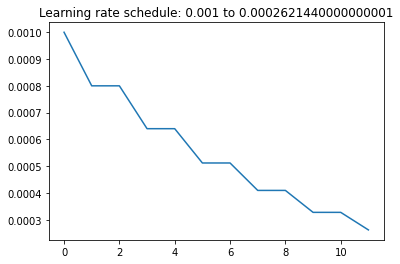

In [ ]:
plt_lr(12)

**KHỞI TẠO CÁC CALLBACK TRONG QUÁ TRÌNH HỌC CỦA MODEL**


> model_checkpoint : Lưu lại trọng số model sau mỗi epoch có val_accuracy đạt max

> lr_schedule : Điều chỉnh learning_rate theo hàm lrfn đã định nghĩa ở trên





In [ ]:
model_checkpoint = ModelCheckpoint('model_checkpoint', monitor='val_accuracy',
                                  verbose=1, save_best_only=True, model='max', save_weights_only=True)
lr_schedule = LearningRateScheduler(lrfn, verbose=True)

**GỌI MODEL VÀ CHO MODEL TRAIN**

In [ ]:
my_model = get_model_resnet()
my_model.summary()

In [ ]:
history = my_model.fit(
    get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH,
    epochs=12,verbose=1, validation_data=get_validation_dataset(),validation_freq=2,
    callbacks=[model_checkpoint, lr_schedule] 
    )

**LƯU VÀ HIỂN THỊ KẾT QUẢ SAU KHI TRAIN MODEL**

In [ ]:
my_model.save("model/resnet50_42label.h5")

In [ ]:
plot_model_history(history, 1, 2)
plt.savefig('resnet50_42label.png')